In [26]:
import argparse

import dgl
import networkx as nx
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from graphregression import *
from models import GraphRegression

import pdb
import random

In [13]:
NUM_BLOCKS = 3

In [2]:
class Args:
    num_samples = 1000
    batch_size = 64
    epochs = 10
    num_test_samples = 10

In [3]:
args = Args()

In [4]:
dataset = dgl.data.SBMMixtureDataset(5, 80, 4)

In [6]:
def sbm(block_size, cov, self_loop=False, directed=False):
    """ (Symmetric) Stochastic Block Model
    https://docs.dgl.ai/generated/dgl.data.SBMMixtureDataset.html?highlight=sbm#dgl.data.SBMMixtureDataset
    
    n_blocks : int
        Number of blocks.
    cov : float
        Matrix with diag terms denoting probability for intra-community edge (within a group, e.g., p), 
        and off diagonal terms the probability for inter-community edge (between two groups, e.g., q).

    Returns dgl.Graph
    """
    n = block_size.sum()
    
    probs = torch.repeat_interleave(cov, block_size, dim=1)
    probs = torch.repeat_interleave(probs, block_size, dim=0)
    
    if directed:
        adj = torch.rand(n,n) < probs
        _from, _to = torch.where(adj & ~torch.eye(n, dtype=bool))        
    else:
        adj = (torch.rand(n,n) < probs).triu(1)
        _from, _to = torch.where(adj+adj.t())
    
    if self_loop:
        return dgl.graph((_from, _to), num_nodes=n).add_self_loop()
    
    return dgl.graph((_from, _to), num_nodes=n)

In [7]:
def sbm_helper(n_blocks, cov, self_loop=False, directed=False):
    block_size = torch.randint(low=5, high=10, size=(n_blocks,))
    g = sbm(block_size, cov, self_loop=False, directed=False)
    g.ndata['y'] = torch.repeat_interleave(torch.arange(n_blocks), block_size).unsqueeze(-1)
    return g

In [18]:
def sample_cov(n, p=0.7, q=0.1, dev=0.01, eps=0.05):
    cov = torch.normal(mean=q*torch.ones(n,n) + (p-q)*torch.eye(n), std=dev).clamp(min=eps, max=1-eps).round(decimals=3)
    return cov.triu() + cov.triu(1).t()

In [11]:
def synthetic_dataset(n, prior, add_self_loop=True):
    labels = [prior(NUM_BLOCKS) for _ in range(n)]
    graphs = [sbm_helper(NUM_BLOCKS, cov, self_loop=add_self_loop) for cov in labels]
    
    return graphs, labels

In [48]:
cov = sample_cov(NUM_BLOCKS, 0.7, 0.1, 0.01)
g = sbm_helper(NUM_BLOCKS, cov, self_loop=False)

In [12]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, n, prior):
        self.n = n
        self.G, self.labels = synthetic_dataset(self.n, prior)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.G[index], self.labels[index]

In [19]:
dataset = Dataset(2, sample_cov)

In [23]:
g = dataset[0][0]

In [21]:
def draw(g, random=True):
    if random:
        colors = np.array(["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                          for i in range(NUM_BLOCKS)])
        colors = colors[g.ndata['y'].squeeze().tolist()]
    else:
        colors = "bgrcmykw"
        colors = [colors[i] for i in g.ndata['y'].squeeze().tolist()]
        
    nx.draw(g.to_networkx(), node_color=colors, arrows=False, with_labels=True)

In [298]:
U, S, V = torch.svd(torch.eye(3).repeat_interleave(torch.randint(4,40, (3,)), dim=0))

In [299]:
S

tensor([6.0828, 4.1231, 3.7417])

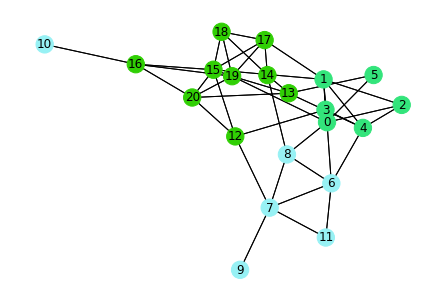

In [27]:
draw(g)

In [49]:
g1, g2 = dataset[0][0], dataset[1][0]

In [52]:
bg = dgl.batch([g1, g2])

In [119]:
def get_mask(bg, num=5):
    return torch.sort(torch.stack([torch.randperm(n)[:num] for n in bg.batch_num_nodes()]), dim=1)[0]

def get_labels(bg):
    return F.one_hot(bg.ndata['y'].squeeze()).to(torch.float32)

def h_star(g, mask, cov, num=5):
    return torch.stack([H[g.successors(nid)].mm(cov[i//num]).log().sum(0) for i, nid in enumerate(mask)])

In [173]:
def get_normalized_features(bg, num=5):
    mask = get_mask(bg, num=num)
    
    # get prior
    H = get_labels(bg)
    n = torch.cat([torch.tensor([0]), torch.cumsum(bg.batch_num_nodes(), dim=0)])
    prior = torch.stack([H[s:t].mean(0) for s,t in zip(n[:-1], n[1:])])

    prior = prior.repeat_interleave(num, dim=0)
    mask = (mask+n[:-1].unsqueeze(-1)).flatten()
    H[mask] = prior
    
    return H, mask  

In [ ]:
def node_classification(args):
    
    model = NodeClassification()
    dataset = Dataset(args.num_samples, sample_cov)
    dataloader = dgl.dataloading.GraphDataLoader(dataset, batch_size=args.batch_size, shuffle=True, drop_last=False)

    opt = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()

    model.train(True)
    for _ in range(args.epochs):
        for batched_graph, cov in dataloader:
            labels = get_labels(batched_graph)
            opt.zero_grad()
            
            feats, mask = get_normalized_features(batched_graph)
            y_hat = model(batched_graph, feats)
            loss = loss_fn(logits[mask], labels[mask])
            loss.backward()
            opt.step()
    
    return model